In [1]:
import pandas as pd
import ee
import geemap
import folium
from IPython.display import Image
import ipyleaflet # to show the map in the notebook

## Packages required for using Dynamic World in a Jupyter Notebook

### How to install the EarthEngine Python package?

`EarthEngine`: 

Installation Tutorial: https://developers.google.com/earth-engine/guides/python_install-conda#mac_6

This tutorial requires the installation of Google Cloud: using the following command:
    
```bash
curl https://sdk.cloud.google.com | bash
```

To authenticate, you should: `earthengine authenticate` as the ee.Authenticate() function is not working. (it only works in Google Colab Notebooks)


### How to authenticate? 
Instructions are here: https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup


### How to install the earthengine command-line tool in the Google Cloud Shell:
        
```bash
curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py && python get-pip.py --user
pip install earthengine-api --upgrade --user
echo 'export PATH="$HOME/.local/bin:$PATH"' >> ~/.bashrc
source ~/.bashrc
```

You can validate this installation by using `earthengine authenticate` in the Google Cloud Shell.
            
- `GeeMap`: 


In [2]:
ee.Initialize(project="jpmorgancapstone")

### What are the bands?

The bands in the s2VisParams variable refer to the Sentinel-2 Harmonized dataset's specific bands used for visualization. Sentinel-2 data has 13 spectral bands, but we typically use a combination of three bands to visualize the data in RGB (red, green, blue) format. In this case, the bands used are:

'B4': The red band (band 4) with a central wavelength of 665 nm and a resolution of 10 meters.
'B3': The green band (band 3) with a central wavelength of 560 nm and a resolution of 10 meters.
'B2': The blue band (band 2) with a central wavelength of 490 nm and a resolution of 10 meters.
These three bands are used to create a true-color composite image that closely resembles how the human eye would perceive the landscape.

The min and max values in the s2VisParams are the minimum and maximum pixel values for visualization. These values are used to scale the brightness of the image. In this case, the pixel values are scaled between 0 and 3000, which is a common choice for Sentinel-2 data to enhance the contrast and improve the overall appearance of the image.

## Test - Matrix Extraction

### Image extraction from the Google Earth Engine

In [3]:
region_large = ee.Geometry.BBox(-104.99,25.08,-85.09,34.93)
region_small = ee.Geometry.BBox(-95.9134,29.2082,-94.4339,30.0581)#-96.8745, 29.0542, -94.1144, 30.6785)
year = 2019

In [15]:
#Initialize the map
Map = geemap.Map()
Map.add_basemap('HYBRID')

In [34]:
startDate = '2019-05-01'
endDate = '2019-09-01'
region = ee.Geometry.BBox(-97.9899,29.0193,-93.0233,30.9926)

image = geemap.dynamic_world_s2(region, startDate, endDate)

landcover = geemap.dynamic_world(region, startDate, endDate, return_type='visualize')
Map.addLayer(landcover, {}, 'Land Cover')

#### Why do we get 648 images?

Yes, I understand why this query returns 648 images. The Sentinel-2 satellite system consists of two satellites (Sentinel-2A and Sentinel-2B), which together provide a revisit time of 5 days at the equator. The query you provided filters the Sentinel-2 Harmonized dataset for images within a specified date range (from January 1, 2019, to January 1, 2020) and region, and with a cloud cover percentage less than 35%.

In the given region and time period, 648 images satisfy these conditions. It is important to note that Sentinel-2 images are divided into granules or tiles, each covering a specific area on the Earth's surface. The query returns all the images of the specified region, which may include overlapping or adjacent granules. The total number of images returned may vary depending on the size of the region, the time period, and the cloud cover conditions.

In [29]:
Map.centerObject(region)

# Plot this first image
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(image, vis_params, 'Sentinel-2 image')
Map

Map(bottom=27337.0, center=[30.005950000707976, -95.50660000000002], controls=(WidgetControl(options=['positio…

## Label extraction from Dynamic World

In [25]:
imageId = s2Image.get('system:index')
# print(imageId)

In [26]:
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
             .filter(ee.Filter.eq('system:index', imageId))

dwImage = ee.Image(dw.first())
print(dwImage)

ee.Image({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "ImageCollection.load",
                "arguments": {
                  "id": {
                    "constantValue": "GOOGLE/DYNAMICWORLD/V1"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "system:index"
                  },
                  "rightValue": {
                    "functionInvocationValue": {
                      "functionName": "Element.get",
                      "arguments": {
                        "ob

In [27]:
classification = dwImage.select('label')
classification

#### Export this image

In [19]:
# import time

# export_params = {
#     'image': classification,
#     'description': 'example_image_export',
#     'folder': '/ge_exports/',  # Google Drive folder name
#     'scale': 10,  # Resolution in meters
#     'region': region,
#     'fileFormat': 'GeoTIFF',
#     'maxPixels': 1e9,  # Increase this value if you encounter an error due to the pixel limit
# }

# export_task = ee.batch.Export.image.toDrive(**export_params)
# export_task.start()

In [28]:
classification = dwImage.select('label')
dwVisParams = {
  'min': 0,
  'max': 8,
  'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
  ]
}

Map.addLayer(classification, dwVisParams, 'Classified Image')
Map

Map(bottom=54531.0, center=[29.6331500009872, -95.17365000000001], controls=(WidgetControl(options=['position'…

## Extract probability values

In [21]:
probabilityBands = [
  'water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
  'built', 'bare', 'snow_and_ice'
]

probabilityImage = dwImage.select(probabilityBands)

# Create the image with the highest probability value at each pixel.
top1Probability = probabilityImage.reduce(ee.Reducer.max())

In [22]:
probabilityImage

In [23]:
top1Probability

## Read a TIFF Image in Python

/var/folders/hk/nxk7bnsj4kq9nwsmnmdtzhb80000gn/T/ipykernel_3321/1375970007.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('../Images/example_image_export.tif')


Shape: (18589, 27060)
Data type: uint8
Minimum value: 0
Maximum value: 8


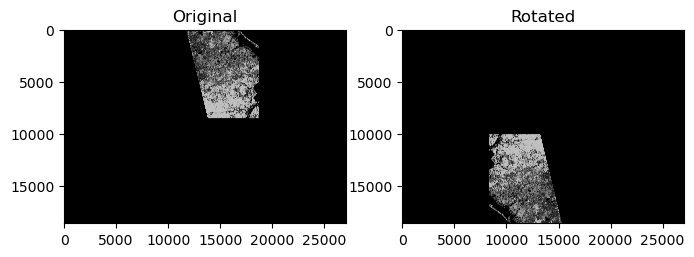

In [1]:
import imageio
import numpy as np

# Load the image
image = imageio.imread('../Images/example_image_export.tif')

# Print some information about the image
print('Shape:', image.shape)
print('Data type:', image.dtype)
print('Minimum value:', image.min())
print('Maximum value:', image.max())

# Rotate the image by 180 degrees
rotated_image = np.rot90(image, 2)

# Display the original and rotated images side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(rotated_image, cmap='gray')
axs[1].set_title('Rotated')
plt.show()


# Create a fishnet

In [72]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Load the shapefile of Texas
tx = gpd.read_file('../Gis/Texas_State_Boundary/State.shp')

# Define the size of each tile in miles
tile_size_miles = 10
tile_size = miles_to_degrees(tile_size_miles, latitude=tx.centroid.y)

# Calculate the size of each grid cell
xmin, ymin, xmax, ymax = tx.total_bounds
x_size = xmax - xmin
y_size = ymax - ymin
num_cols = round(x_size / tile_size) # 5280 feet in a mile
num_rows = round(y_size / tile_size)

# Create the fishnet polygons
fishnet_polys = []
for i in tqdm(range(num_rows)):
    for j in range(num_cols):
        # Calculate the coordinates of the fishnet cell corners
        x_left = xmin + j * tile_size
        x_right = xmin + (j + 1) * tile_size
        y_bottom = ymin + i * tile_size
        y_top = ymin + (i + 1) * tile_size

        # Create a polygon for the fishnet cell
        poly = Polygon([(x_left, y_bottom), (x_right, y_bottom),
                        (x_right, y_top), (x_left, y_top)])
        fishnet_polys.append(poly)

# Create a GeoDataFrame from the fishnet polygons
fishnet = gpd.GeoDataFrame({'id': range(len(fishnet_polys)),
                            'geometry': fishnet_polys},
                           crs=tx.crs)

# Clip the fishnet to the Texas boundary
# fishnet = gpd.overlay(fishnet, tx, how='intersection')

/var/folders/hk/nxk7bnsj4kq9nwsmnmdtzhb80000gn/T/ipykernel_24278/3848732635.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tile_size = miles_to_degrees(tile_size_miles, latitude=tx.centroid.y)
100%|██████████| 63/63 [00:00<00:00, 1379.10it/s]


In [73]:
xmin, ymin, xmax, ymax 

(-106.64622979299997,
 25.837224320000075,
 -93.50780658199994,
 36.50038609100005)

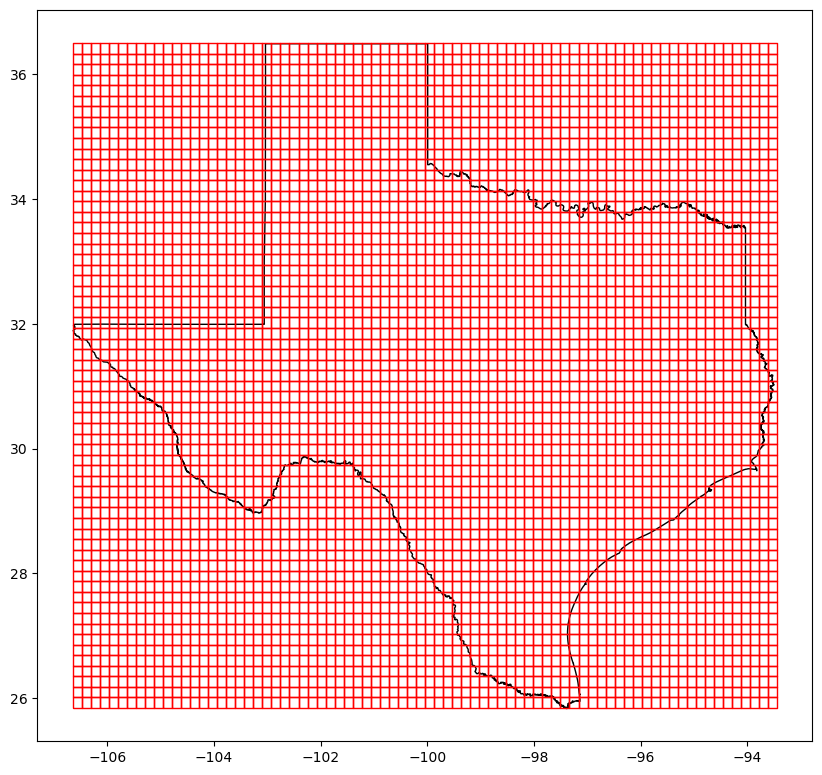

In [75]:
# plot the fishnet
fig, ax = plt.subplots(figsize=(10, 10))
tx.plot(ax=ax, color='white', edgecolor='black')
fishnet.plot(ax=ax, color='none', edgecolor='red')
plt.show()

In [41]:
fishnet

,id,geometry
0,0,"POLYGON ((-106.64623 25.83722, 658.57116 25.83..."
1,1,"POLYGON ((658.57116 25.83722, 1423.78855 25.83..."
2,2,"POLYGON ((1423.78855 25.83722, 2189.00594 25.8..."
3,3,"POLYGON ((2189.00594 25.83722, 2954.22334 25.8..."
4,4,"POLYGON ((2954.22334 25.83722, 3719.44073 25.8..."
...,...,...
6565,6565,"POLYGON ((64936.83203 55121.48940, 65702.04942..."
6566,6566,"POLYGON ((65702.04942 55121.48940, 66467.26681..."
6567,6567,"POLYGON ((66467.26681 55121.48940, 67232.48420..."
6568,6568,"POLYGON ((67232.48420 55121.48940, 67997.70160..."


In [33]:
fishnet

,id,geometry
0,0,"POLYGON ((-106.64623 25.83722, 658.57116 25.83..."
1,1,"POLYGON ((658.57116 25.83722, 1423.78855 25.83..."
2,2,"POLYGON ((1423.78855 25.83722, 2189.00594 25.8..."
3,3,"POLYGON ((2189.00594 25.83722, 2954.22334 25.8..."
4,4,"POLYGON ((2954.22334 25.83722, 3719.44073 25.8..."
...,...,...
6565,6565,"POLYGON ((64936.83203 55121.48940, 65702.04942..."
6566,6566,"POLYGON ((65702.04942 55121.48940, 66467.26681..."
6567,6567,"POLYGON ((66467.26681 55121.48940, 67232.48420..."
6568,6568,"POLYGON ((67232.48420 55121.48940, 67997.70160..."


ValueError: aspect must be finite and positive 

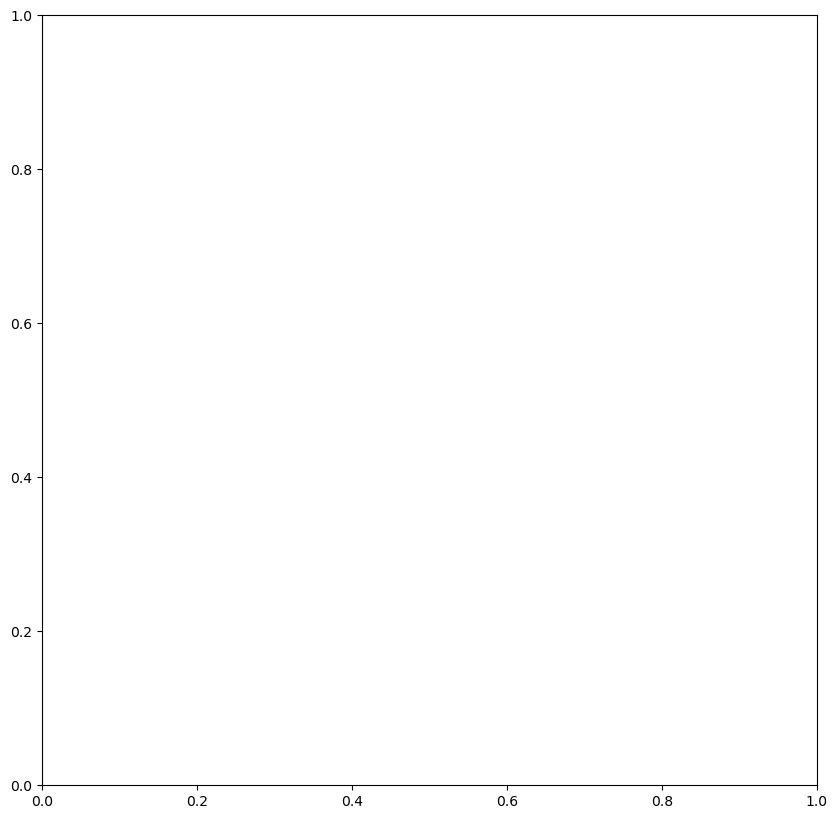

In [36]:
# plot the fishnet
fig, ax = plt.subplots(figsize=(10, 10))
tx.plot(ax=ax, color='white', edgecolor='black')
fishnet.plot(ax=ax, color='none', edgecolor='red')
plt.show()

In [9]:
print(tx.crs)
print(fishnet.crs)

EPSG:4326
EPSG:4326


ValueError: aspect must be finite and positive 

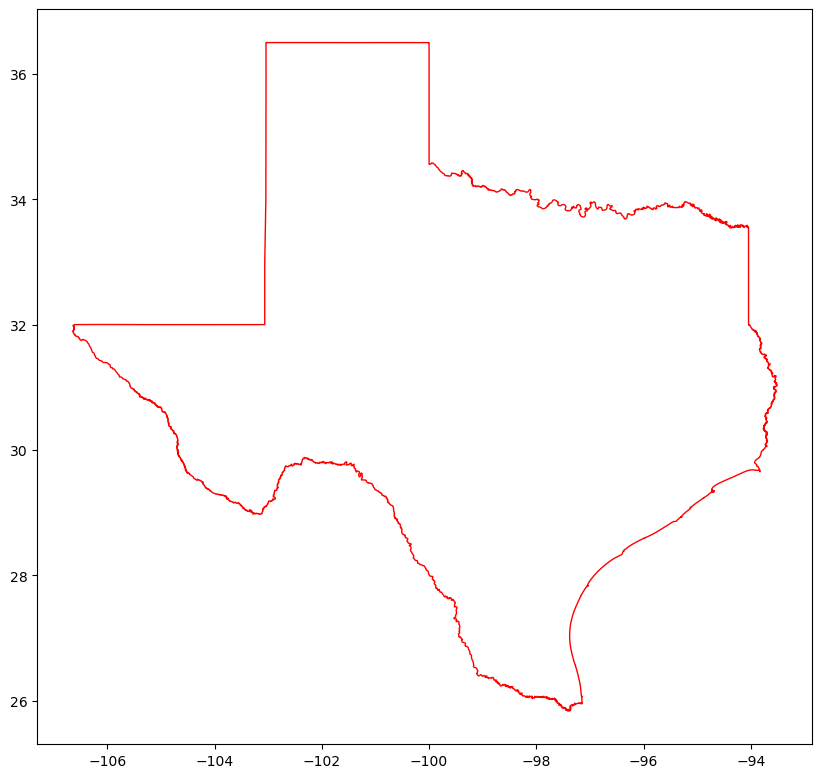

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
tx.plot(ax=ax, facecolor='none', edgecolor='red')
fishnet.plot(ax=ax, facecolor='blue', alpha=0.5)
plt.show()


In [20]:
x_size

13.138423211000031

100%|██████████| 735/735 [00:05<00:00, 124.12it/s]


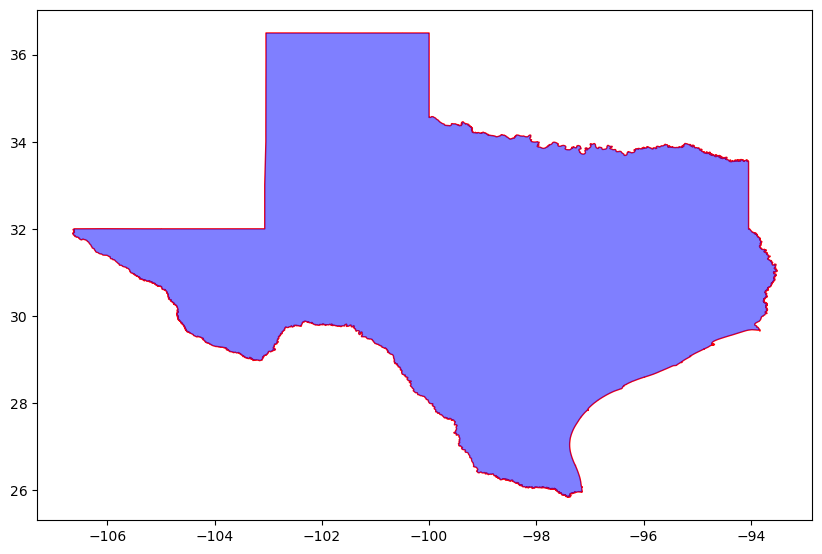

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the shapefile of Texas
tx = gpd.read_file('../Gis/Texas_State_Boundary/State.shp')

# Create the fishnet GeoDataFrame

# Define the size of each tile in miles
tile_size = 1 / 69 # approximate conversion of miles to degrees

# Calculate the size of each grid cell
xmin, ymin, xmax, ymax = tx.total_bounds
x_size = xmax - xmin
y_size = ymax - ymin
num_cols = int(x_size / tile_size) # 5280 feet in a mile --> 0.25*5280 = 1320
num_rows = int(y_size / tile_size)

# Create the fishnet polygons
fishnet_polys = []
for i in tqdm(range(num_rows)):
    for j in range(num_cols):
        # Calculate the coordinates of the fishnet cell corners
        x_left = xmin + j * tile_size * 5280
        x_right = xmin + (j+1) * tile_size * 5280
        y_bottom = ymin + i * tile_size * 5280
        y_top = ymin + (i+1) * tile_size * 5280

        # Create a polygon for the fishnet cell
        poly = Polygon([(x_left, y_bottom), (x_right, y_bottom),
                        (x_right, y_top), (x_left, y_top)])
        fishnet_polys.append(poly)

# Create a GeoDataFrame from the fishnet polygons
fishnet = gpd.GeoDataFrame({'id': range(len(fishnet_polys)),
                            'geometry': fishnet_polys},
                           crs=tx.crs)

# Clip the fishnet to the Texas boundary
# fishnet = gpd.overlay(fishnet, tx, how='intersection')

# Plot the Texas map and the fishnet
fig, ax = plt.subplots(figsize=(10, 10))
tx.plot(ax=ax, facecolor='none', edgecolor='red')
fishnet.plot(ax=ax, facecolor='blue', alpha=0.5)

# Set the aspect ratio of the plot based on the size of the image
x_size = ax.get_xlim()[1] - ax.get_xlim()[0]
y_size = ax.get_ylim()[1] - ax.get_ylim()[0]
aspect_ratio = y_size / x_size
ax.set_aspect(aspect_ratio)

# Show the plot
plt.show()


In [24]:
fishnet

,id,OBJECTID,FIPS,CREATE_USE,CMNT,SHAPE_Leng,SHAPE_Area,geometry
0,0,1,48,TPP,NaN,56.835385,65.729229,"POLYGON ((-100.49461 36.49989, -100.48794 36.4..."
